<a href="https://colab.research.google.com/github/jstarace/CS_504_Assignment3_Vakanski/blob/main/CS504_Vakanski_Assignment_3_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### The following is a complete walk-through of Assignment #3 for CS 504: ST Adversarial Machine Learning, taught by Dr. Vakanski at the University of Idaho in the Spring of 2023.  The assignment is being made available to assist in the understanding of future related assignments at the request of Dr. Vakanski.


## The assignment is broken down into 2 parts.
1. Adversarial Traning defense against evasion attacks
1. Poisoning attacks against deep learning classification models

For this assignment I used Google Colab for the training of the models and completion of the assignment. It is recommend that the same or similar is used.


# Notebook Setup

## Setup and Configuration

Before diving into the assignment we want to make sure our environment has all the necessary libraries and connections

In [1]:
# Connect to Google Drive.
# All images required for the assignment were either provided by Dr. Vakanski or were publicly available
# Images were loaded onto google drive for ease of access

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install the adversarial robustness toolbox so that we can work with adversarial models
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


## Imports

In [41]:
# For inline matplot use
%matplotlib inline

# Import the following libraries

import os
import cv2
import sys
import keras
import random
import imageio
import tarfile
import natsort
import warnings
import numpy as np
import tensorflow as tf
import keras.backend as k
import matplotlib.pyplot as plt

In [44]:
# From installed and available libraries import these specific classes

from os import listdir

from keras.models import Model
from keras.applications import vgg16
#from keras.preprocessing import image
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping 
#from keras.applications.imagenet_utils import preprocess_input

from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
#from tensorflow.tools.docs.doc_controls import T
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

#from art.estimators.classification import KerasClassifier
#from art.estimators.classification import SklearnClassifier

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.defences.transformer.poisoning import NeuralCleanse

#from art.attacks.poisoning import PoisoningAttackBackdoor
#from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
#from art.utils import to_categorical, load_mnist, preprocess
#from art.defences.detector.poison import ActivationDefence
#from art.defences.transformer.poisoning import NeuralCleanse

from skimage.util import compare_images
# from IPython.display import clear_output
from matplotlib.gridspec import GridSpec
# from skimage import data, transform, exposure

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay

from re import U

from mpl_toolkits import mplot3d

In [5]:
# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Supress warnings
warnings.filterwarnings('ignore')

In [6]:
# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

TensorFlow version:2.12.0
Keras version:2.12.0
Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Definitions

The following are the definitions for methods we will use during the assignment

### Plotting loss and accuracy

In [7]:
# Simple method used to print a models accuracy and loss.  Pass the method
# the history and both accuracy and loss will be displayed

def plot_accuracy_loss(the_history):
    # plot the accuracy and loss
    train_loss = the_history.history['loss']
    val_loss = the_history.history['val_loss']
    acc = the_history.history['accuracy'] 
    val_acc = the_history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

### Model Definitions

In [8]:
# For this assignment transfer learning was used for the base models.
# Specifically resnet models were used.  You may note that when using the
# models provided by Keras, their documentation mentions preprocessing
# the images.  This is intentionally left out as it caused issues with the
# accuracy of the predicitions.

# As the inputs and classes may change we pass those as variables to provide a
# more robust method for use.
def build_vgg16(input_shape, class_count):

  base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

  # Add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # Add a fully-connected layer
  x = Dense(2048, activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(x)
  # Add a softmax layer 
  predictions = Dense(class_count, activation='softmax')(x)

  # The model 
  model = Model(inputs=base_model.input, outputs=predictions)

  return model

### Helper methods

In [9]:
# Generate an array of unique random ints used for selecting random indices
def random_array(c, upper):
  random_list = []
  while len(random_list) < c:
    #for i in range(c):
    r = random.randint(0, upper-1)
    if r not in random_list:
      random_list.append(r)
  return random_list

# Get a subset from provided array
def get_subset(subset, provided_images, provided_labels):
  temp_img = []
  temp_labels = []
  for x in subset:
    temp_img.append(provided_images[x])
    temp_labels.append(provided_labels[x])
  temp_img = np.array(temp_img, dtype = np.float32)
  temp_labels = np.array(temp_labels, dtype = np.float32)
  return temp_img, temp_labels

### Image Loader

In [10]:
def load_images(directory):

    imgs_list = []

    # List of all images in the directory
    imgs_list_1 = listdir(directory)
    # Make sure that the images are sorted 
    imagesList = natsort.natsorted(imgs_list_1)

    # Read the images as numpy arrays
    for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
          img_arr = np.array(tmp_img)
          imgs_list.append(img_arr/255.)
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

### Global Variables

In [11]:
# Label Encoder for loading in data
le = LabelEncoder()

# Define a save path for use when training models
save_path = '/content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/Saves/'

# Define the path for weights to be stored
weight_path = 'Weights/'

# Define the path for the model to be stored
model_path = 'Models/'

# Define the extention for weights/models
ext = '.h5'

### Poisoning Attack

In [47]:
def add_modification(x):
  if BACKDOOR_TYPE == 'pattern':
      return add_pattern_bd(x, pixel_value=max_val)
  elif BACKDOOR_TYPE == 'pixel':
      return add_single_bd(x, pixel_value=max_val) 
  elif BACKDOOR_TYPE == 'image':
      return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
  else:
      raise("Unknown backdoor type")

def add_pattern_bd(x: np.ndarray, distance: int = 2, pixel_value: int = 1) -> np.ndarray:
  """
  Augments a matrix by setting a checkboard-like pattern of values some `distance` away from the bottom-right
  edge to 1. Works for single images or a batch of images.
  :param x: N X W X H matrix or W X H matrix or N X W X H X C matrix, pixels will ne added to all channels
  :param distance: Distance from bottom-right walls.
  :param pixel_value: Value used to replace the entries of the image matrix.
  :return: Backdoored image.
  """
  x = np.array(x)
  shape = x.shape
  if len(shape) == 4:
    width, height = x.shape[1:3]
    x[:, width - distance -1, height - distance -1, :] = pixel_value
    x[:, width - distance -1, height - distance - 3, :] = pixel_value
    x[:, width - distance -1, height - distance - 5, :] = pixel_value
    x[:, width - distance -1, height - distance - 7, :] = pixel_value
    x[:, width - distance - 3, height - distance -1, :] = pixel_value
    x[:, width - distance - 5, height - distance -1, :] = pixel_value
    x[:, width - distance - 7, height - distance -1, :] = pixel_value
    x[:, width - distance - 2, height - distance - 2, :] = pixel_value
    x[:, width - distance - 4, height - distance - 2, :] = pixel_value
    x[:, width - distance - 6, height - distance - 2, :] = pixel_value
    x[:, width - distance - 2, height - distance - 4, :] = pixel_value
    x[:, width - distance - 2, height - distance - 6, :] = pixel_value
    x[:, width - distance - 3, height - distance - 3, :] = pixel_value
    x[:, width - distance - 3, height - distance - 5, :] = pixel_value
    x[:, width - distance - 5, height - distance - 3, :] = pixel_value
    x[:, width - distance - 4, height - distance - 4, :] = pixel_value

  elif len(shape) == 3:
    width, height = x.shape[1:]
    x[:, width - distance, height - distance] = pixel_value
    x[:, width - distance - 1, height - distance - 1] = pixel_value
    x[:, width - distance, height - distance - 2] = pixel_value
    x[:, width - distance - 2, height - distance] = pixel_value
  elif len(shape) == 2:
    width, height = x.shape
    x[width - distance, height - distance] = pixel_value
    x[width - distance - 1, height - distance - 1] = pixel_value
    x[width - distance, height - distance - 2] = pixel_value
    x[width - distance - 2, height - distance] = pixel_value
  else:
    raise ValueError("Invalid array shape: " + str(shape))
  return x

def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
  x_poison = np.copy(x_clean)
  y_poison = np.copy(y_clean)
  is_poison = np.zeros(np.shape(y_poison))

  # Sources: benign images, label 0
  # Targets: malignant images, label 1
  # We want to misclassify 20% of the benign images as malignant
  # The labels for sources and targets seems to be wrong
  sources = np.array([0])
  targets = np.array([1])
  for i, (src, tgt) in enumerate(zip(sources, targets)):
    n_points_in_tgt = np.size(np.where(y_clean == tgt))
    num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
    src_imgs = x_clean[y_clean == src]

    n_points_in_src = np.shape(src_imgs)[0]
    indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

    imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
    backdoor_attack = PoisoningAttackBackdoor(poison_func)
    imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
    x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
    y_poison = np.append(y_poison, poison_labels, axis=0)
    is_poison = np.append(is_poison, np.ones(num_poison))

  is_poison = is_poison != 0

  return is_poison, x_poison, y_poison

# Part 2

## Step 1

**About the data**

Add this

### Load Data

In [12]:
# Uncompress the dataset 
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/data/BUS_images.zip" -d "sample_data/"

In [13]:
# Load the images
all_images = load_images('sample_data/BUS_images')
print('Shape of the images:', all_images.shape)

# Load the labels
all_labels = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/data/labels_BUSimages.csv', delimiter=',', dtype=str)
image_labels = le.fit_transform(all_labels)
print('Shape of the labels:', image_labels.shape)

Shape of the images: (780, 224, 224, 3)
Shape of the labels: (780,)


In [14]:
# Split the data into 2 sets of data
# 1. A trainval set that will later be split into the training and validation sets
# 2. A test set which will be 20% of all data

# By setting the random state, we can ensure consistency when creating the datasets
# This allows us to focus on fine tuning our models
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, image_labels, test_size=0.2, random_state=12)

# Using the trainval sets, we split the data again into our training and validation sets
# The validation set will be 20% of the remaining data and the remainder will be 
# our training set
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)

# With all the necessary info loaded, we can free up space by deleting the imported images
del all_images

In [15]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

# A list with the names of the image classes
label_names = np.unique(all_labels)

del all_labels

Images train shape: (499, 224, 224, 3) - Labels train shape: (499,)
Images validation shape: (125, 224, 224, 3) - Labels validation shape: (125,)
Images test shape: (156, 224, 224, 3) - Labels test shape: (156,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.3254926794323271
Data type float64


### Display images

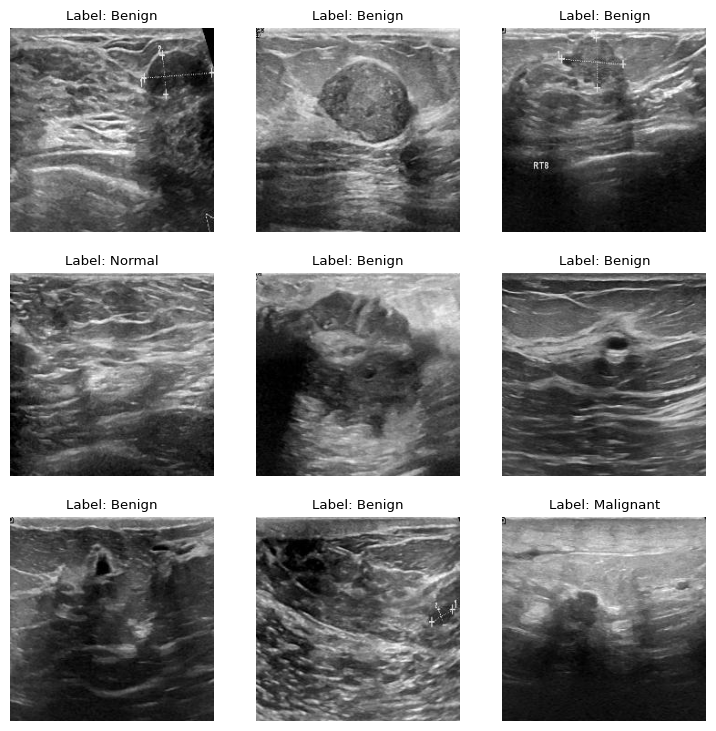

In [16]:
# Plot a few images to check if the labels make sense
plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size': 8})
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label: ' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

### Train a deep learning model above 80% accuracy

#### Paths and variables

In [17]:
weight_name = 'bd_weights_'
bd = 'bd/'

In [18]:
input = (224, 224, 3)
NUM_CLASSES = len(label_names)
batch = 32
epochs = 100
iterations = 1

In [19]:
adam = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5)

model_monitor = EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=50,
                            verbose=0,
                            mode='auto')

#### Train the model

In [21]:
accuracy = []
histories = []

for i in range(iterations):
  model = build_vgg16(input, NUM_CLASSES)
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer = adam,
              metrics=['accuracy'])
  print("Iteration: " + str(i+1) + " of " + str(iterations))
  path = save_path + weight_path + weight_name + str(i) + ext
  print("Weights will be saved here: " + path)
  model_checkpointer = ModelCheckpoint(path,
                                       verbose = 1,
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'auto')
  history = model.fit(
      train_images,
      train_labels,
      verbose=1,
      epochs = epochs,
      batch_size = batch,
      callbacks = [model_monitor, model_checkpointer],
      validation_data = (val_images, val_labels)
  )

  histories.append(history)
  loss_test, accuracy_test = model.evaluate(test_images, test_labels)
  print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))
  accuracy.append(accuracy_test)

58889256/58889256 [==============================] - 3s 0us/step
Iteration: 1 of 1
Weights will be saved here: /content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/Saves/Weights/bd_weights_0.h5
Train on 499 samples, validate on 125 samples
Epoch 1/100
499/499 [==============================] - ETA: 0s - loss: 1.0135 - accuracy: 0.5170
Epoch 1: val_loss improved from inf to 1.03883, saving model to /content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/Saves/Weights/bd_weights_0.h5
499/499 [==============================] - 21s 41ms/sample - loss: 1.0135 - accuracy: 0.5170 - val_loss: 1.0388 - val_accuracy: 0.5040
Epoch 2/100
480/499 [===========================>..] - ETA: 0s - loss: 0.9607 - accuracy: 0.5771
Epoch 2: val_loss improved from 1.03883 to 0.99643, saving model to /content/drive/MyDrive/Colab Notebooks/CS_504/Assignment_3/Saves/Weights/bd_weights_0.h5
499/499 [==============================] - 2s 3ms/sample - loss: 0.9585 - accuracy: 0.5792 - val_loss: 0.9964 - val

#### Validate the best model and load it

In [22]:
## Print the index with the best accuracy
best = [index for index, item in enumerate(accuracy) if item ==max(accuracy)]
the_value = best[0]
print("The best index is: " + str(the_value))

The best index is: 0


In [23]:
best_model = build_vgg16(input, NUM_CLASSES)
best_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=adam,
                metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

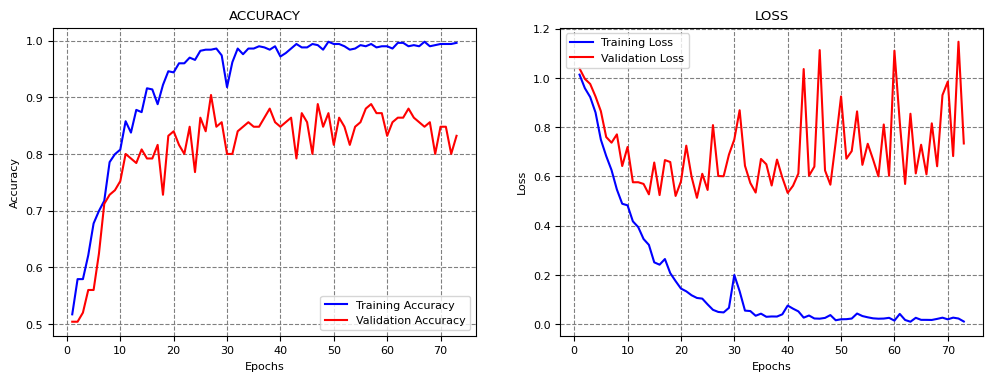

Accuracy on test data: 87.18%


In [24]:
best_path = save_path + weight_path + weight_name + str(the_value) + ext
best_model.load_weights(best_path)
best_model.summary()
plot_accuracy_loss(histories[the_value])
best_loss_test, best_accuracy_test = best_model.evaluate(test_images, test_labels)
print('Accuracy on test data: {:4.2f}%'.format(best_accuracy_test * 100))

#### Save best model
This allows us to skip retraining the model should we need to come back to this at a later time

In [25]:
best_model.save(save_path + model_path + bd)

#### Report accuracy for benign, malignant & normal images

In [39]:
# Generate prediction on test images
pred = np.argmax(best_model.predict(test_images), axis=1)

# Count actual values
benign_count = np.sum(test_labels == 0)
malignant_count = np.sum(test_labels == 1)
normal_count = np.sum(test_labels == 2)

# Count correct predicted values
pred_benign_count = 0
pred_malignant_count = 1
pred_normal_count = 2

for x in pred:
  if x == test_labels[i] and x == 0:
    pred_benign_count += 1
  elif x == test_labels[i] and x == 1:
    pred_malignant_count += 1
  elif x == test_labels[i] and x == 2:
    pred_normal_count += 1
  i += 1

# Report
print("\t{}\t\t{}\t{}".format(label_names[0], label_names[1], label_names[2]))
print("\t{:4.2f}%\t\t{:4.2f}%\t\t{:4.2f}%".format((pred_benign_count/benign_count)*100,
                                                  (pred_malignant_count/malignant_count)*100,
                                                  (pred_normal_count/normal_count)*100))

	Benign		Malignant	Normal
	86.81%		88.89%		96.55%


#### Discuss

When viewing the results, one might ask, "why is the model much more accurate when predicting normal images?".  This can be expected, the difficulty in separating the images into the group is not in determining if there is or isn't cancerous cells, it's determining if the cells are malignant or benign.  So, detecting there are no concerns would be the simplest validation and therefore should have the higher accuracy

## Step 2

### Load in the model from Step 1

In [26]:
the_model = keras.models.load_model(save_path + model_path + bd)
the_model.summary()
loss, acc = the_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Decide on the type of backdoor attack

For this assignment we've decided to modify the 'add_pattern_bd' function in the image_perturbations file from the ART toolbox, to create a patter with 16 pixels.

In [46]:
BACKDOOR_TYPE = "pattern"

## Part 3

### Create a poisoned dataset

In [48]:
max_val = np.max(train_images)
print(max_val)

percent_poison = .20
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(trainval_images, trainval_labels, percent_poison, add_modification)
x_train, y_train = x_poisoned_raw, y_poisoned_raw

1.0


In [51]:
# Validate shapes
print("The shape of the training image set: ", x_train.shape)
print("The shape of the training label set: ", y_train.shape)

The shape of the training image set:  (668, 224, 224, 3)
The shape of the training label set:  (668,)


### Plot images

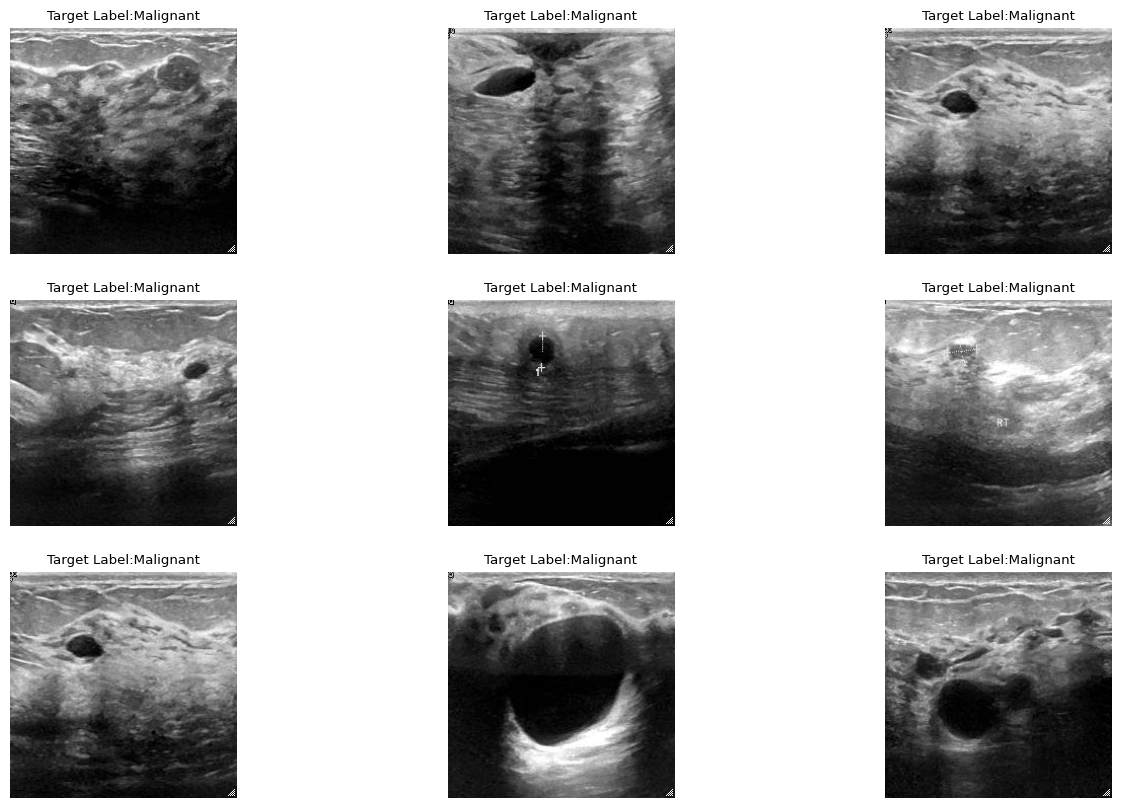

In [53]:
# Plot a few images 
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(len(x_train)-40, len(x_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(x_train[i[0]])
    plt.title('Target Label:' + str(label_names[int(y_train[i[0]])]))
    plt.axis('off')

## Step 4

### Poison the test data

In [54]:
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(test_images, test_labels, percent_poison, add_modification)
x_test, y_test = x_poisoned_raw_test, y_poisoned_raw_test

#### Validate shape

In [55]:
print("Test dataset shape", x_test.shape)

Test dataset shape (165, 224, 224, 3)


#### Shuffle the dataset

In [56]:
# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

## Step 5

### Train a poisoned model

In [57]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))
classifier.fit(x_train, y_train, nb_epochs=15, batch_size=16)

Train on 668 samples
Epoch 1/15
668/668 [==============================] - 4s 6ms/sample - loss: 0.7643 - accuracy: 0.7590
Epoch 2/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.3757 - accuracy: 0.8638
Epoch 3/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.3256 - accuracy: 0.8907
Epoch 4/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.2476 - accuracy: 0.9042
Epoch 5/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.2132 - accuracy: 0.9222
Epoch 6/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.1822 - accuracy: 0.9222
Epoch 7/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.1418 - accuracy: 0.9491
Epoch 8/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.1162 - accuracy: 0.9656
Epoch 9/15
668/668 [==============================] - 1s 2ms/sample - loss: 0.0725 - accuracy: 0.9760
Epoch 10/15
668/668 [==============================] - 1s 2ms

## Step 6

### Evaluate the poisoned model with clean test images

#### Create a clean dataset for use

In [58]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]
print(clean_x_test.shape)
print(clean_y_test.shape)

(156, 224, 224, 3)
(156,)


#### Generate predictions and validate accuracy

In [59]:
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == clean_y_test)
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))


Clean test set accuracy: 87.82%


#### Plot images

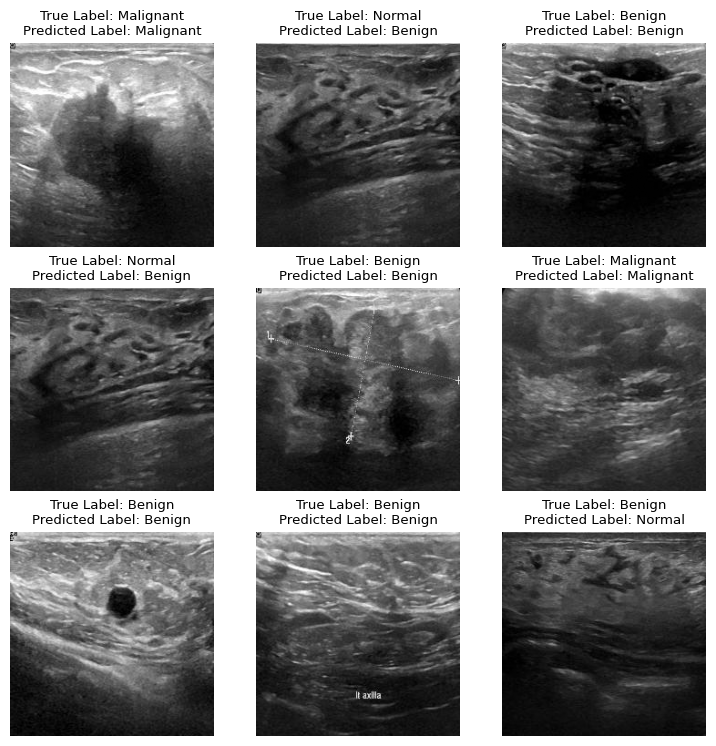

In [61]:
plt.figure(figsize=(9, 9))
plt.rcParams.update({'font.size':8})
for n in range(9):
    i = np.random.randint(0, len(clean_x_test), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(clean_x_test[i[0]])
    plt.title('True Label: {}\nPredicted Label: {}'.format(str(label_names[int(clean_y_test[i[0]])]), str(label_names[clean_preds[i[0]]])))
    plt.axis('off')

## Step 7

### Evaluate the model on poisoned test images.

#### Create the poisoned dataset and report shape

In [62]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]
print("Shape of poisoned dataset:",poison_x_test.shape)

Shape of poisoned dataset: (9, 224, 224, 3)


#### Generate predictions and report accuracy

In [63]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == poison_y_test)
poison_total = poison_y_test.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))


Poison test set accuracy: 77.78%


#### Report Bengin images misclassified as malignant

In [69]:
miss_class = 0

for x in range(len(poison_preds)):
  if poison_preds[x] == 1  and poison_y_test[x] == 0:
    miss_class += 1

print("There were {} images predicted as malignant that were actually benign".format(miss_class))

There were 0 images predicted as malignant that were actually benign


#### Display images

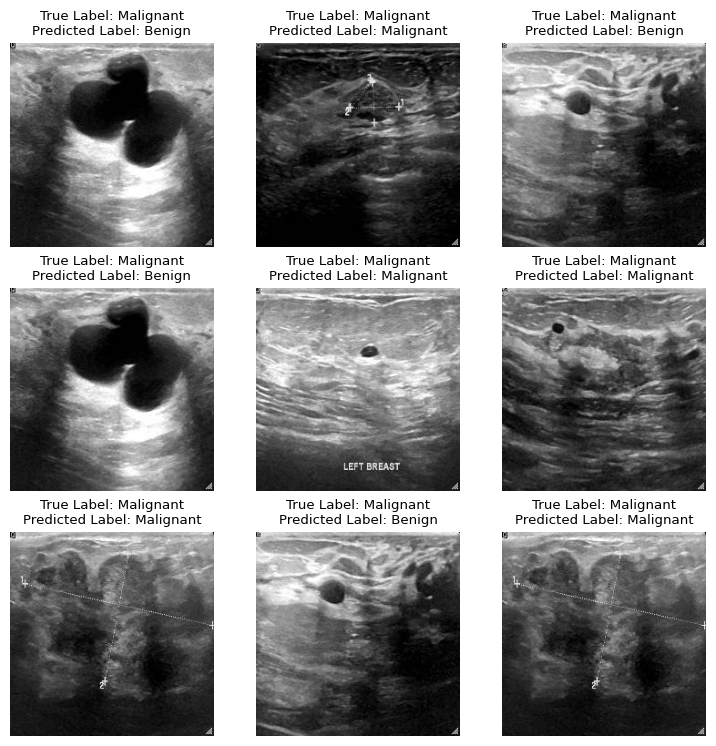

In [64]:
plt.figure(figsize=(9, 9))
for n in range(9):
  i = np.random.randint(0, len(poison_x_test), 1)
  ax = plt.subplot(3, 3, n+1)
  plt.imshow(poison_x_test[i[0]])
  plt.title('True Label: {}\nPredicted Label: {}'.format(str(label_names[int(poison_y_test[i[0]])]), str(label_names[poison_preds[i[0]]])))
  plt.axis('off')